In [1]:
#prepare data
#choose different n for prediction of T+n; label response series accordingly
import pandas as pd
import numpy as np

df = pd.read_csv("merged.csv")
df['ret'] = df['close'].pct_change()

In [2]:
#prepare the labels
#label1: predict buy(1) or sell(-1) for T+14 days
change14= df['close'].pct_change(14)

#make 3 dataframes for the 3 models
data = df[['volume','close-open_%of_close','high-low_%of_close',
       'macd', '50d_avg', '100d_avg', '200d_avg', 'so', 'oil', 'gold',
       'vix','ust10', 'ust5vs2', 'ust10vs2']]

In [3]:
data14 = data
data14['change'] = change14[14:].reset_index(drop=True)

/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
data14['label'] = np.where(data14['change']>=0, 1, -1)
data14.dropna(inplace=True)
print(data14.isnull().values.ravel().sum())

0


/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
data14.head()
data14.columns

Index(['volume', 'close-open_%of_close', 'high-low_%of_close', 'macd',
       '50d_avg', '100d_avg', '200d_avg', 'so', 'oil', 'gold', 'vix', 'ust10',
       'ust5vs2', 'ust10vs2', 'change', 'label'],
      dtype='object')

In [6]:
x14 = data14[['volume', 'close-open_%of_close', 'high-low_%of_close', 'macd',
       '50d_avg', '100d_avg', '200d_avg', 'so', 'oil', 'gold', 'vix', 'ust10',
       'ust5vs2', 'ust10vs2']]
y14 = data14['label']

In [7]:
x14.to_csv("x14.csv")
y14.to_csv('y14.csv')

In [8]:
from numpy import genfromtxt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as Data
import os

In [9]:
def take_block(x, win_size=60):
    ret = list()
    for i in range(win_size, len(x)):
        ret.append(x[i - win_size:i])
    return np.stack(ret, axis=0)

In [10]:
k = pd.read_csv('x14.csv', index_col=0).head(5)
k.as_matrix().shape

/home/shiyun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(5, 14)

In [11]:
def genfromtxt(x_filename, y_filename, win_size):
    
    X = pd.read_csv(x_filename, index_col=0).values
    X = (X - X.mean(axis=-1, keepdims=True)) / X.std(axis=-1, keepdims=True)
    Y = pd.read_csv(y_filename, index_col=0, header=None).values
    Y[Y==-1]=0
    
    ret_X, ret_Y = list(), list()
    for i in range(win_size, len(X)-1):
        ret_X.append(X[i - win_size:i])
        ret_Y.append(Y[i+1])
    ret_X = np.stack(ret_X, axis=0).reshape(-1,1,win_size,X.shape[1])
    ret_Y = np.stack(ret_Y, axis=0).reshape(-1,Y.shape[1])
    
    # normalize

    
    return ret_X, ret_Y

In [12]:
ret_X, ret_Y = genfromtxt('x14.csv', 'y14.csv', 60)
X_train = ret_X[:3000,...]
y_train = ret_Y[:3000,...]
X_test = ret_X[3600:,...]
y_test = ret_Y[3600:,...]
X_dev = ret_X[3000:3600]
y_dev = ret_Y[3000:3600]

In [33]:
len(y_test)

682

In [13]:
def wrap_data(inputs, labels):
    return torch.from_numpy(inputs).float(), torch.from_numpy(labels).long()

In [14]:
X_test, y_test = wrap_data(X_test, y_test)
X_dev, y_dev = wrap_data(X_dev, y_dev)
X_train, y_train = wrap_data(X_train, y_train)

In [15]:
#convert data to tensor
test_dataset = Data.TensorDataset(
    X_train.float(),
    y_train.long())

train_dataset = Data.TensorDataset(
    X_train.float(),
    y_train.long())

In [16]:
#input pipeline
input_size = 18
hidden_size1 = 30
hidden_size2 = 30
num_classes = 2
num_epochs = 2
batch_size = 32
learning_rate = 0.001


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
classes = (-1,1)

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, 
                 channels_in, 
                 channels_out1, 
                 channels_out2,
                 kernel_size1,
                 kernel_size2,
                 hid_size1,
                 hid_size2):
        super(Net, self).__init__()
        self.channels_in = channels_in
        self.channels_out1 = channels_out1
        self.channels_out2 = channels_out2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.hid_size1 = hid_size1
        self.hid_size2 = hid_size2
        
        
        assert self.kernel_size1 % 2 == 1, 'must be odd'
        assert self.kernel_size2 % 2 == 1, 'must be odd'
        self.conv1 = nn.Conv2d(self.channels_in, self.channels_out1 , self.kernel_size1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(self.channels_out1, self.channels_out2, self.kernel_size2)
        h = 60 - (self.kernel_size1 - 1)
        w = 19 - (self.kernel_size1 - 1)
        h = h // 2
        w = w // 2
        h = h - (self.kernel_size2 - 1)
        w = w - (self.kernel_size2 - 1)
        h = h // 2
        w = w // 2
        self.h = h 
        self.w = w
        self.fc1 = nn.Linear(self.channels_out2 * h * w, self.hid_size1)
        self.fc2 = nn.Linear(self.hid_size1, self.hid_size2)
        self.fc3 = nn.Linear(self.hid_size2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.channels_out2 * self.h * self.w)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
#set up parameters and hyper parameters
channels_in = 1
channels_out1 = 2
channels_out2 = 2
kernel_size1 = 5
kernel_size2 = 5
hid_size1 = 20
hid_size2 = 20

net = Net(channels_in, channels_out1, channels_out2, kernel_size1, kernel_size2, hid_size1, hid_size2)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-4)

In [22]:
def get_loss(inputs, labels, training=True):
    
    if training:
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1,))
    else:
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels.view(-1,))
    return loss, outputs
        

In [25]:
def get_accuracy(X, y):
    test_loss, test_outputs = get_loss(X, y, training=False)

    return (test_outputs.argmax(dim=-1).view(-1) == y.view(-1)).sum().float() / y.shape[0]

In [32]:
from tqdm import tqdm
from copy import deepcopy

best_loss = np.inf
lst_dev_accuracy = []
lst_test_accuracy = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    all_outputs = 0.0
    for i, data in enumerate(train_loader, 1):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss, outputs = get_loss(inputs, labels, training=True)
        all_outputs += (outputs[:, 1] >= outputs[:, 0]).sum().item()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        check_freq = 10
        if i % check_freq == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f ones %.3f' %
                  (epoch + 1, i, running_loss / float(check_freq), all_outputs / float(check_freq)))
            running_loss = 0.0
            print()
            all_outputs = 0.0
            
    # evaluate on dev set
    
    dev_loss, outputs = get_loss(X_dev, y_dev, training=False)
    test_loss, test_outputs = get_loss(X_test, y_test, training=False)
    dev_loss = dev_loss.item()
    test_loss = test_loss.item()
    

    
    print((outputs[:, 1] > outputs[:, 0]).sum())
    if dev_loss < best_loss:
        best_params = deepcopy(net.state_dict())
        best_loss = dev_loss
    accuracy_dev = get_accuracy(X_dev, y_dev)
    accuracy_test = get_accuracy(X_test, y_test)
    
    lst_dev_accuracy.append(accuracy_dev)
    lst_test_accuracy.append(accuracy_test)
    
    print('dev_loss is %.4f, best_loss is %.4f, accuracy is %.4f' %(dev_loss, best_loss, accuracy_dev))
    print('test_loss is %.4f, best_loss is %.4f, accuracy is %.4f' %(dev_loss, best_loss, accuracy_test))

print('Finished Training')

[1,    10] loss: 0.592 ones 25.300

[1,    20] loss: 0.607 ones 26.600

[1,    30] loss: 0.616 ones 27.000

[1,    40] loss: 0.630 ones 27.900

[1,    50] loss: 0.643 ones 25.200

[1,    60] loss: 0.617 ones 27.000

[1,    70] loss: 0.622 ones 25.500

[1,    80] loss: 0.592 ones 25.700

[1,    90] loss: 0.619 ones 26.200

tensor(600)
dev_loss is 0.7473, best_loss is 0.7473, accuracy is 0.5933
test_loss is 0.7473, best_loss is 0.7473, accuracy is 0.6745
[2,    10] loss: 0.621 ones 25.900

[2,    20] loss: 0.592 ones 26.600

[2,    30] loss: 0.648 ones 26.900

[2,    40] loss: 0.581 ones 25.100

[2,    50] loss: 0.596 ones 26.900

[2,    60] loss: 0.623 ones 26.000

[2,    70] loss: 0.633 ones 27.600

[2,    80] loss: 0.629 ones 25.400

[2,    90] loss: 0.595 ones 26.900

tensor(600)
dev_loss is 0.7554, best_loss is 0.7473, accuracy is 0.5933
test_loss is 0.7554, best_loss is 0.7473, accuracy is 0.6745
[3,    10] loss: 0.621 ones 26.500

[3,    20] loss: 0.613 ones 27.700

[3,    30] los

[19,    10] loss: 0.606 ones 26.700

[19,    20] loss: 0.540 ones 26.400

[19,    30] loss: 0.581 ones 25.700

[19,    40] loss: 0.578 ones 25.700

[19,    50] loss: 0.589 ones 26.700

[19,    60] loss: 0.605 ones 26.800

[19,    70] loss: 0.609 ones 25.900

[19,    80] loss: 0.605 ones 26.300

[19,    90] loss: 0.618 ones 26.900

tensor(600)
dev_loss is 0.7601, best_loss is 0.7353, accuracy is 0.5933
test_loss is 0.7601, best_loss is 0.7353, accuracy is 0.6745
[20,    10] loss: 0.615 ones 26.300

[20,    20] loss: 0.594 ones 25.900

[20,    30] loss: 0.596 ones 24.900

[20,    40] loss: 0.575 ones 26.900

[20,    50] loss: 0.594 ones 27.100

[20,    60] loss: 0.616 ones 25.400

[20,    70] loss: 0.577 ones 25.500

[20,    80] loss: 0.567 ones 26.800

[20,    90] loss: 0.581 ones 27.400

tensor(600)
dev_loss is 0.7885, best_loss is 0.7353, accuracy is 0.5933
test_loss is 0.7885, best_loss is 0.7353, accuracy is 0.6745
[21,    10] loss: 0.586 ones 27.100

[21,    20] loss: 0.586 ones 27

[36,    90] loss: 0.523 ones 26.100

tensor(581)
dev_loss is 0.8955, best_loss is 0.7353, accuracy is 0.5950
test_loss is 0.8955, best_loss is 0.7353, accuracy is 0.6246
[37,    10] loss: 0.522 ones 26.400

[37,    20] loss: 0.562 ones 25.700

[37,    30] loss: 0.536 ones 25.600

[37,    40] loss: 0.560 ones 25.000

[37,    50] loss: 0.501 ones 24.900

[37,    60] loss: 0.527 ones 24.900

[37,    70] loss: 0.556 ones 24.800

[37,    80] loss: 0.535 ones 24.100

[37,    90] loss: 0.525 ones 24.900

tensor(573)
dev_loss is 0.8595, best_loss is 0.7353, accuracy is 0.5983
test_loss is 0.8595, best_loss is 0.7353, accuracy is 0.6085
[38,    10] loss: 0.491 ones 23.900

[38,    20] loss: 0.519 ones 21.800

[38,    30] loss: 0.555 ones 24.300

[38,    40] loss: 0.552 ones 24.900

[38,    50] loss: 0.517 ones 23.000

[38,    60] loss: 0.526 ones 24.800

[38,    70] loss: 0.537 ones 25.900

[38,    80] loss: 0.540 ones 25.200

[38,    90] loss: 0.512 ones 25.900

tensor(578)
dev_loss is 0.8985,

In [27]:
net.load_state_dict(best_params)

In [31]:
net

Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=24, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

In [39]:
x = np.asarray([t.item() for t in lst_test_accuracy])

In [40]:
y = np.asarray([t.item() for t in lst_dev_accuracy])

In [43]:
import matplotlib.pyplot as plt


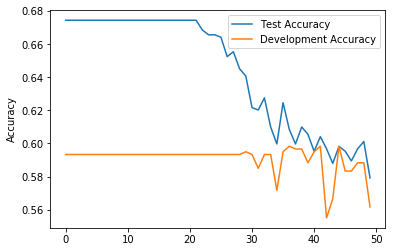

In [59]:
plt.plot(range(len(x)), x)
plt.plot(range(len(x)), y)
         
plt.ylabel('Accuracy')
plt.legend(['Test Accuracy', 'Development Accuracy'])
plt.show()

In [65]:
list(y).index(y.max())

36

In [66]:
list(x)[36]

0.6085044145584106

In [67]:
list(y)[36]

0.5983333587646484